In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, models, transforms

import numpy as np

import PIL
import pickle
from skimage import io
from PIL import Image
from pathlib import Path
import os
import copy

from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

from tqdm.notebook import tqdm

# Подготовка изображений

In [2]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 299x299 px для inception
RESCALE_SIZE = 299
# работаем на видеокарте
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TRAIN_DIR = Path('../input/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('../input/journey-springfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [3]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])

        if self.mode == 'test':
            x = self._prepare_sample(x)
            x = transform(x)    
            return x
        else:
            # добавляем аугментацию для train изображений
            transform_test = transforms.Compose([ 
                transforms.RandomRotation(degrees=30),
                transforms.RandomHorizontalFlip(),
                transforms.RandomPerspective(distortion_scale=0.2, p=0.4),
                transforms.RandomApply([transforms.CenterCrop(size=(220, 220))], p=0.5),
                transforms.RandomApply([transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))], p=0.4),
                transforms.Resize([299, 299]),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            x = transform_test(x) 
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [4]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [5]:
val_dataset = SimpsonsDataset(val_files, mode='val')
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [6]:
n_classes = len(np.unique(train_val_labels))

# Визуализация датасета

In [7]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:594: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of the returned value whenever m > n. In torch.linalg.lstsq, the residuals in the field 'residuals' of the returned named tuple.
The unpacking of the solution, as in
X, _ = torch.lstsq(B, A).solution[:A.size(1)]
should be replaced with
X = torch.linalg.lstsq(A, B).solution (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/LegacyTHFunctionsCPU.cpp:389.)
  res = torch.lstsq(b_matrix, a_matrix)[0]


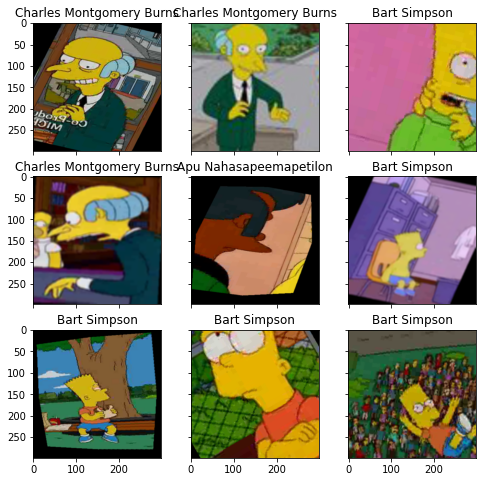

In [8]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

# Обучение модели

In [9]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [10]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc


In [11]:
def train(train_files, val_files, model, epochs, batch_size, optimizer, criterion, scheduler, deacrease_epochs=5):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    # init variables to store best model weights, best accuracy, best epoch number, epochs since best accuracy acheived
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    epochs_since_best = 0

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        # opt = torch.optim.Adam(model.parameters())
        # criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            scheduler.step()
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

            # сохранение лучшей модели
            if val_acc > best_acc:
                best_acc = val_acc
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
            else:
                epochs_since_best += 1
            
            # Остановка обучение, если модель не обучается в течение deacrease_epochs эпох
            if epochs_since_best > deacrease_epochs:
                print(f'Stopping training. The validation accuracy has been decreasing for {deacrease_epochs} epochs.')
                break
    model.load_state_dict(best_model_wts)
    return history

In [12]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

# inception v3

In [13]:
model_extractor = models.inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [14]:
model_extractor.AuxLogits.fc = nn.Linear(768, n_classes)
model_extractor.fc = nn.Linear(2048, n_classes)

optimizer = optim.Adam(model_extractor.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model_extractor.aux_logits = False
model_extractor.to(DEVICE)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [15]:
history = train(train_dataset, val_dataset, model=model_extractor, criterion=loss_fn,
                             epochs=25, batch_size=64, optimizer=optimizer, scheduler=exp_lr_scheduler, deacrease_epochs=7)

epoch:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

loss 1.3628963709705249

Epoch 001 train_loss: 1.3629     val_loss 0.5262 train_acc 0.6761 val_acc 0.8729


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.47718903637487076

Epoch 002 train_loss: 0.4772     val_loss 0.4129 train_acc 0.8809 val_acc 0.8936


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.27824186241342364

Epoch 003 train_loss: 0.2782     val_loss 0.2915 train_acc 0.9266 val_acc 0.9251


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.21869913902421068

Epoch 004 train_loss: 0.2187     val_loss 0.2415 train_acc 0.9403 val_acc 0.9406


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.18461603893088008

Epoch 005 train_loss: 0.1846     val_loss 0.2606 train_acc 0.9519 val_acc 0.9375


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.15939533380764612

Epoch 006 train_loss: 0.1594     val_loss 0.2756 train_acc 0.9564 val_acc 0.9282


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.13558287289926402

Epoch 007 train_loss: 0.1356     val_loss 0.2007 train_acc 0.9646 val_acc 0.9522


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.06135925339577355

Epoch 008 train_loss: 0.0614     val_loss 0.1540 train_acc 0.9836 val_acc 0.9664


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.05058430129555017

Epoch 009 train_loss: 0.0506     val_loss 0.1400 train_acc 0.9866 val_acc 0.9706


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.051479148729351644

Epoch 010 train_loss: 0.0515     val_loss 0.1472 train_acc 0.9878 val_acc 0.9685


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.04298958029327244

Epoch 011 train_loss: 0.0430     val_loss 0.1360 train_acc 0.9893 val_acc 0.9704


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.03766232504198474

Epoch 012 train_loss: 0.0377     val_loss 0.1556 train_acc 0.9894 val_acc 0.9690


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.038502265286270425

Epoch 013 train_loss: 0.0385     val_loss 0.1541 train_acc 0.9903 val_acc 0.9685


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.03461713302344002

Epoch 014 train_loss: 0.0346     val_loss 0.1367 train_acc 0.9911 val_acc 0.9713


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.029932979164849504

Epoch 015 train_loss: 0.0299     val_loss 0.1382 train_acc 0.9918 val_acc 0.9713


  0%|          | 0/246 [00:00<?, ?it/s]

loss 0.029379837247296696

Epoch 016 train_loss: 0.0294     val_loss 0.1468 train_acc 0.9929 val_acc 0.9702
Stopping training. The validation accuracy has been decreasing for 7 epochs.


In [16]:
# save the weights of our net
model_weights = copy.deepcopy(model_extractor.state_dict())
torch.save(model_weights, "inception.pth")

In [17]:
# загружаем сохраненное состояние весов нейросети
model_extractor.load_state_dict(torch.load("inception.pth"))

<All keys matched successfully>

# Submit на Kaggle

In [18]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [19]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_extractor, ex_img.unsqueeze(0))

In [20]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_extractor, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [21]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_extractor, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [22]:
import pandas as pd
#my_submit = pd.read_csv("../input/journey-springfield/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv('inc_model_baseline.csv', index=False)